- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** September 2024  
- **Conda env file and code examples**: https://github.com/MRC-CBU/COGNESTIC/

# fMRI Analysis on Windows using WSL and Containers

We recommend running neuroimaging analyses in a High Performance Computing (HPC) environment on Linux systems. The COGNESTIC workshop materials are designed to work almost out of the box in such environments. Check with your department and consult your IT team to see what resources are available. It is unlikely that running neuroimaging analyses on a laptop would be expected. However, if an HPC environment is unavailable and you need to use your Windows computer, here are some guidelines to help you proceed.

These guidelines were tested on:

>**Windows 11 Enterprise, Version 23H2**  
>**Processor**: Intel(R) Core(TM) i5-10600 CPU @ 3.30GHz (6 cores, 12 threads)  
>**RAM**: 16 GB  

**Table of contents**<a id='toc0_'></a>    
1. [Windows Subsystem for Linux (WSL) and Apptainer/Docker Containers](#toc1_)    
2. [Setting Up Your Windows System](#toc2_)    
2.1. [Install and Set Up Windows Subsystem for Linux (WSL)](#toc2_1_)    
2.1.1. [Step 1: Installation](#toc2_1_1_)    
2.1.2. [Step 2: Check That WSL Has DNS Servers Set Up](#toc2_1_2_)    
2.1.3. [Step 3: Mount the Drive Containing Your Data](#toc2_1_3_)    
2.2. [Install Apptainer](#toc2_2_)    
2.2.1. [Step 1: Update and Install Dependencies](#toc2_2_1_)    
2.2.2. [Step 2: Add the Apptainer PPA](#toc2_2_2_)    
2.2.3. [Step 3: Install Apptainer](#toc2_2_3_)    
2.2.4. [Step 4: Verify Installation](#toc2_2_4_)    
2.3. [Pull Apptainer Containers](#toc2_3_)    
2.4. [Alternatively, Install Docker and Pull Docker Containers](#toc2_4_)    
2.5. [Create Conda Environments within WSL](#toc2_5_)    
2.5.1. [Install Miniconda](#toc2_5_1_)    
2.5.2. [Create a New Conda Environment for fMRI Analysis](#toc2_5_2_)    
3. [Allocating More System Resources to WSL](#toc3_)    
3.1. [Step 1: Create or Edit the `.wslconfig` File](#toc3_1_)    
3.2. [Step 2: Configure Resource Limits](#toc3_2_)    
3.3. [Step 3: Restart WSL](#toc3_3_)    
4. [Installing FSL in WSL](#toc4_)    
5. [Running COGNESTIC's fMRI materials](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Windows Subsystem for Linux (WSL) and Apptainer/Docker Containers](#toc0_)

**Windows Subsystem for Linux (WSL)** allows you to run a full Linux distribution alongside your existing Windows installation without needing a virtual machine. It provides a lightweight environment where you can run Linux-based tools, scripts, and software directly on your Windows system. This is especially beneficial for fMRI analysis, as many neuroimaging tools are designed for Linux.

While you can set up and run Conda environments and Jupyter notebooks on Windows, using WSL offers better compatibility with Linux-based neuroimaging packages, making it a more robust and stable environment for complex fMRI workflows.

**Apptainer** (formerly Singularity) is a container technology specifically designed for high-performance computing (HPC) environments, making it an excellent choice for neuroimaging workflows. One of the key advantages of Apptainer is its ability to handle security and compatibility issues more efficiently than Docker, especially when running on multi-user systems like HPC clusters. Apptainer integrates well with WSL, providing a seamless way to run neuroimaging containers while maintaining the necessary permissions and file access.

On the other hand, **Docker** is also widely used in the neuroimaging community for distributing tools. However, Docker comes with some disadvantages compared to Apptainer. Docker runs as a daemon with root privileges, which can introduce security concerns, particularly in shared environments. Additionally, Docker's interaction with the underlying file system in WSL can sometimes lead to performance overheads, especially when dealing with large neuroimaging datasets.

We recommend using Apptainer containers for better performance and security on WSL, and compatibility with HPC. However, Docker remains a viable option if you prefer its ecosystem. 

## 2. <a id='toc2_'></a>[Setting Up Your Windows System](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Install and Set Up Windows Subsystem for Linux (WSL)](#toc0_)

#### 2.1.1. <a id='toc2_1_1_'></a>[Step 1: Installation](#toc0_)
Follow the instructions on the official Microsoft page to install WSL:  
[Install WSL](https://learn.microsoft.com/en-us/windows/wsl/install)

Once installed, open **Command Prompt** and type: `wsl`

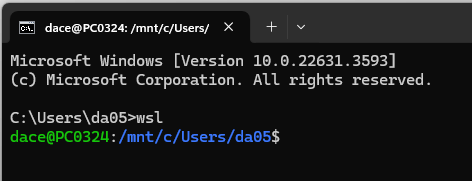

**Note:** All the following operations in these guidelines should be executed in the WSL terminal.

#### 2.1.2. <a id='toc2_1_2_'></a>[Step 2: Check That WSL Has DNS Servers Set Up](#toc0_)

By default, WSL might not automatically use the DNS servers from the host operating system, which can result in a lack of internet access. If this happens, you won't be able to download any packages or access websites.

To check if this is the issue, run the following command in your WSL terminal: `ping google.com`

If it returns an error (such as "Temporary failure in name resolution"), you need to manually set up DNS servers. You can do this with the following steps:

1. Open your WSL terminal and run: `sudo nano /etc/wsl.conf`
   This will open *wsl.conf* file in editing mode. Add the following configuration:  
   `[network]`  
   `generateResolvConf = false`  

   Save and exit (in nano, press CTRL + X, then Y, and Enter).

2. Delete the auto-generated *resolv.conf* file: `sudo rm /etc/resolv.conf`
   
3. Create a new resolv.conf: `sudo touch /etc/resolv.conf`
   
4. Set it to be writable: `sudo chmod 644 /etc/resolv.conf`

5. Open the *resolv.conf* file by running: `sudo nano /etc/resolv.conf`  
   This will open the *resolv.conf* file in editing mode.  
   Add these lines to specify DNS servers:  
    `nameserver 8.8.8.8`  
    `nameserver 8.8.4.4`
   
   Save and exit (in nano, press CTRL + X, then Y, and Enter).

   This should work on most networks. However, some networks do not allow the use of external DNS servers due to security considerations, so you need to determine the servers currently in use by Windows (e.g., by `nslookup` command in Windows Command Prompt) or ask your network administrator. 

6. Verify your internet access by running the ping command again: `ping google.com`

If the issue was related to DNS, this should resolve it.

#### 2.1.3. <a id='toc2_1_3_'></a>[Step 3: Mount the Drive Containing Your Data](#toc0_)

For example, if your data is on the C: drive, mount it with this command: `sudo mount -t drvfs C: /mnt/c`

### 2.2. <a id='toc2_2_'></a>[Install Apptainer](#toc0_)

To install Apptainer on your WSL environment, it's preferable to use the [Personal Package Archive (PPA) method](https://apptainer.org/docs/admin/main/installation.html#install-ubuntu-packages). This ensures you have access to the latest stable release of Apptainer, along with automatic updates when newer versions are released.

Follow these steps to install Apptainer:

#### 2.2.1. <a id='toc2_2_1_'></a>[Step 1: Update and Install Dependencies](#toc0_)

First, ensure your package list is up to date, and install the necessary dependencies for Apptainer:

```bash
sudo apt update
sudo apt install -y \
    build-essential \
    libseccomp-dev \
    pkg-config \
    squashfs-tools \
    cryptsetup
```

#### 2.2.2. <a id='toc2_2_2_'></a>[Step 2: Add the Apptainer PPA](#toc0_)

Next, add the Apptainer PPA repository to your WSL installation:

`sudo add-apt-repository ppa:apptainer/ppa`

After adding the repository, update your package list again:

`sudo apt update`

#### 2.2.3. <a id='toc2_2_3_'></a>[Step 3: Install Apptainer](#toc0_)

Now, install Apptainer:

`sudo apt install -y apptainer`

#### 2.2.4. <a id='toc2_2_4_'></a>[Step 4: Verify Installation](#toc0_)

Once the installation is complete, verify that Apptainer is installed correctly by checking the version:

`apptainer --version`

You should see the installed version of Apptainer printed in the terminal.

### 2.3. <a id='toc2_3_'></a>[Pull Apptainer Containers](#toc0_)

To **pull the fMRIPrep container**, first navigate to the directory where you want to store your container images. Then, use the following command to pull the container image from DockerHub:

`apptainer pull docker://nipreps/fmriprep`

This will download the container and create a file named *fmriprep_latest.sif* in your current directory.

It's a good idea to rename the `.sif` file to include the container's version for better organisation. You can check the version of the container with this command:

`apptainer exec /mnt/c/COGNESTIC/apptainer_images/fmriprep_latest.sif fmriprep --version`

This will return the version number, for example, `fMRIPrep v24.1.0`. After confirming the version, you can rename the `.sif` file accordingly:

`mv fmriprep_latest.sif fmriprep_v24.1.0.sif`

Now, you have the container image correctly named with its version, making it easier to manage and reference.

Next, in a similar way, **pull the MRIQC container**:

1) Pull the image: `apptainer pull docker://nipreps/mriqc` 
2) Check the version: `apptainer exec /mnt/c/COGNESTIC/apptainer_images/mriqc_latest.sif mriqc --version`  
3) Rename the file: `mv mriqc_latest.sif mriqc_v24.1.0.sif`

### 2.4. <a id='toc2_4_'></a>[Alternatively, Install Docker and Pull Docker Containers](#toc0_)

Apptainer is generally recommended for neuroimaging workflows, particularly when security, performance, and HPC compatibility are important factors. However, if instead of Apptainer, you want to use the Docker Desktop, here are the basic steps.

1) Ensure your system meets the requirements! You can download Docker Desktop here: [Docker Desktop](https://www.docker.com/products/docker-desktop)
2) Enable WSL integration in Docker Desktop: Navigate to *Docker Desktop → Settings → Resources → WSL Integration* and enable integration for your WSL distributions.  
3) Run the following command to check if Docker is active: `docker -h`
4) Use Docker to pull the necessary containers: in the WSL terminal type
   * `docker pull nipreps/mriqc`  
   * `docker pull nipreps/fmriprep`  

### 2.5. <a id='toc2_5_'></a>[Create Conda Environments within WSL](#toc0_)

Many neuroimaging tools, like Nilearn, are built for Linux environments. Using WSL ensures smoother installation and better compatibility with these tools. While you can run Conda and Jupyter on Windows, running them within WSL provides a more stable environment, especially for complex workflows involving Linux-specific libraries and packages. 

#### 2.5.1. <a id='toc2_5_1_'></a>[Install Miniconda](#toc0_)

You can install Miniconda (a lightweight version of Anaconda) directly in your WSL environment. To do so, follow these steps:

```bash
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh
```

Follow the on-screen prompts and restart your terminal after installation.

#### 2.5.2. <a id='toc2_5_2_'></a>[Create a New Conda Environment for fMRI Analysis](#toc0_)

You can use the `mri_environment.yml` file included in the COGNESTIC materials to create the `mri` conda environment we have been using in the workshop. To do so, navigate to the directory where the `.yml` file is located (for example, `cd /mnt/c/COGNESTIC/`) and use the following command to create the environment:

`conda env create -f mri_environment.yml`

This will create the `mri` environment with all the specified packages.

## 3. <a id='toc3_'></a>[Allocating More System Resources to WSL](#toc0_)

By default, WSL dynamically allocates up to 50% of your total system memory and all available CPU cores to your Linux environment. You might want to adjust these resource limits manually to improve performance. You can do this by editing the `.wslconfig` file to allocate more memory or restrict the number of CPU cores.

You can monitor the WSL resources, such as CPU and memory usage, in real time by using the `htop` command (You might need to install it first if it doesn't exist; `sudo apt install htop`). This command provides a visual representation of your CPU, RAM, and swap usage, allowing you to keep track of resource consumption during intensive tasks, such as running fMRI analysis workflows.

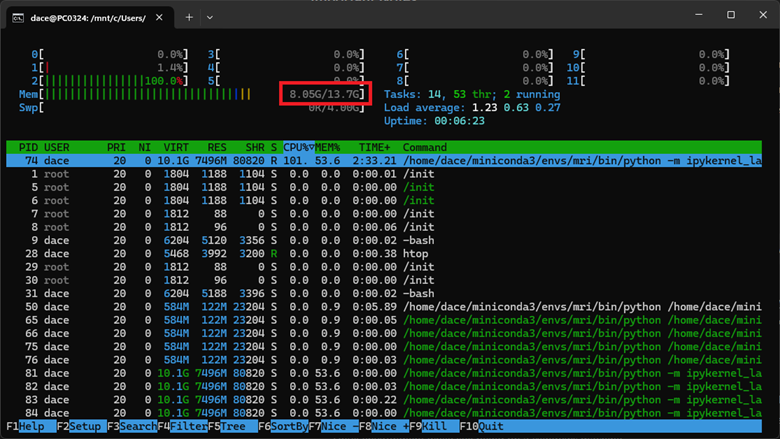

**Steps to Adjust Resource Allocation:**

### 3.1. <a id='toc3_1_'></a>[Step 1: Create or Edit the `.wslconfig` File](#toc0_)

In your Windows home directory (*C:\Users\<your-username>*), create or edit a file named `.wslconfig` using a text editor.

### 3.2. <a id='toc3_2_'></a>[Step 2: Configure Resource Limits](#toc0_)

Add the following configuration to adjust memory and CPU allocation:

```bash
[wsl2]
memory=12GB # Allocate 12 GB of RAM (default is 50% of total RAM on Windows)
processors=12 # Allocate 12 logical processors (default is all logical processors on Windows)
```

Adjust the values based on your system’s total available resources. **It's recommended to leave at least 4 GB of RAM for the operating system!**

Our test system had 16 GB of RAM. With the default 50% allocation (8 GB), running the fMRI first-level and group-level notebooks failed. For example, during the first-level analysis, the GLM fit of the nine runs used up to 12 GB of RAM, while the group-level permutation testing required up to 13.3 GB. After increasing the WSL memory allocation to 14 GB, the notebooks ran without issues. However, leaving only 2 GB RAM for the OS can strain the system and potentially cause problems for the PC's performance. 

### 3.3. <a id='toc3_3_'></a>[Step 3: Restart WSL](#toc0_)

After modifying the `.wslconfig`, run the following command in **Command Prompt** or **PowerShell** to restart WSL: `wsl --shutdown`  
This will apply the new resource limits the next time you start WSL.

## 4. <a id='toc4_'></a>[Installing FSL in WSL](#toc0_)

Within WSL you can also quite easily install FSL (and possibly Freesurfer, but we did not test that). Follow the instructions for FSL installation on Linux: https://fsl.fmrib.ox.ac.uk/fsl/docs/#/install/linux

In the WSL terminal: 
1) Download the installer file https://fsl.fmrib.ox.ac.uk/fsldownloads/fslconda/releases/fslinstaller.py
2) Run: `python ~/Downloads/fslinstaller.py`  
Follow the on-screen prompts to complete the installation.

To use FSL's GUI tools, such as **FSLeyes**, you’ll need to install additional libraries. For example, we installed the following packages to enable graphical functionality:

```bash
sudo apt update
sudo apt install libgl1-mesa-glx
sudo apt install gsettings-desktop-schemas
sudo apt-get install --reinstall libgtk-3-common
```

Once installed, you should be able to launch FSL's GUI tools within WSL, provided you have the necessary graphical support through WSLg (Windows 11) or an X server (Windows 10).


## 5. <a id='toc5_'></a>[Running COGNESTIC's fMRI materials](#toc0_)

Once you have your system set up, you can try it out by running the COGNESTIC's fMRI materials (scripts and notebooks; you will also need all the sample data for that). 

You can run the Jupyter Notebooks just like we did during the workshops on the virtual machines. You can launch the notebooks by following these steps:

* Start the WSL terminal: in Windows Command Prompt type `wsl`
* Navigate to the directory with the notebooks. For example, `cd /mnt/c/COGNESTIC/05_fMRI`
* Activate the environment: `conda activate mri`
* Start the Jupyter lab: `jupyter lab` - This will generate a URL that you can open in your web browser to access the notebooks (the browser might not launch automatically, in that case, copy the URL and paste it into the web browser).

For the MRIQC and fMRIPrep we have prepared slightly modified example scripts. They are on the [GitHub](https://github.com/MRC-CBU/COGNESTIC/tree/main/05_fMRI) in *code-examples* and start with *apptainer_*/*docker_*. 
